<a href="https://colab.research.google.com/github/kennardmah/house-price-prediction/blob/main/AP5_Cleaned_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

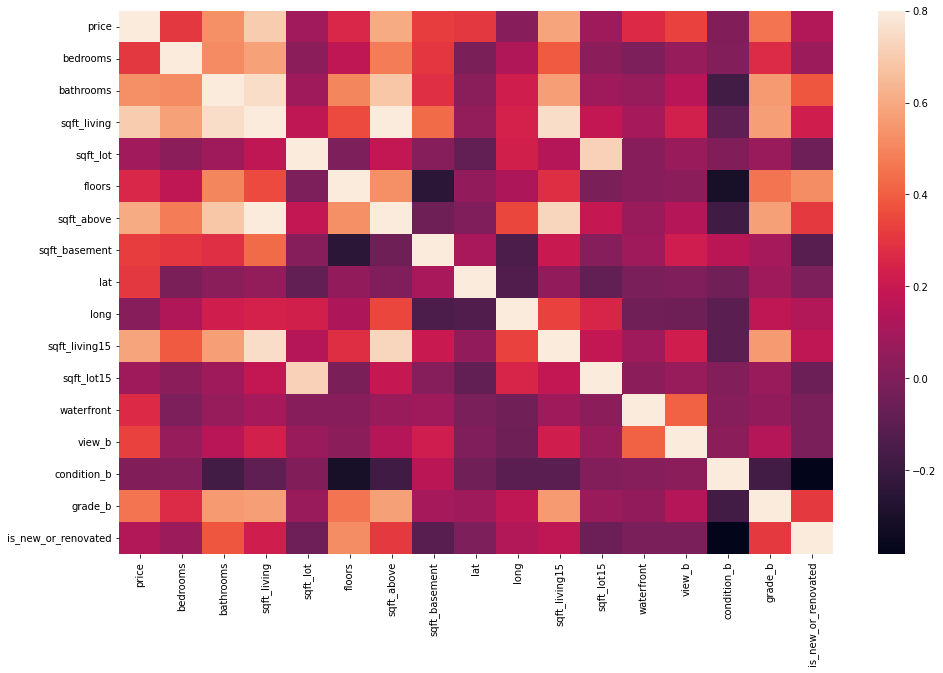

condition_b            0.0042
long                   0.0216
sqft_lot15             0.0824
sqft_lot               0.0897
is_new_or_renovated    0.1375
floors                 0.2568
waterfront             0.2664
lat                    0.3070
bedrooms               0.3083
sqft_basement          0.3238
view_b                 0.3379
grade_b                0.4546
bathrooms              0.5251
sqft_living15          0.5854
sqft_above             0.6056
sqft_living            0.7020
price                  1.0000
Name: price, dtype: float64

In [48]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import seaborn as sns

hdf = pd.read_csv('kc_house_data.csv')
hdf = pd.DataFrame(hdf)

# hdf.info()

hdf = hdf.drop(columns=['id','date','zipcode'])

continuous_hdf = hdf[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']]
categorical_hdf = hdf.drop(columns=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15'])

hdf = pd.concat([continuous_hdf, categorical_hdf], axis=1)

hdf.to_csv('kc_house_reorganised.csv')


hdf['view_b'] = hdf['view'] > 2
hdf['view_b'] = hdf['view_b'].astype(int)
hdf['condition_b'] = hdf['condition'] > 3
hdf['condition_b'] = hdf['condition_b'].astype(int)
hdf['grade_b'] = hdf['grade'] > 7
hdf['grade_b'] = hdf['grade_b'].astype(int)

def label_new(row):
    if row['yr_renovated'] > 2000 :
        return '1'
    elif row['yr_built'] > 2000 :
        return '1'
    else:
        return '0'

hdf['is_new_or_renovated'] = hdf.apply(lambda row: label_new(row), axis=1)
hdf['is_new_or_renovated'] = hdf['is_new_or_renovated'].astype(int)

# print(hdf['is_new_or_renovated'])

hdf = hdf.drop(columns=['view','grade','condition','yr_built','yr_renovated'])


train, other = train_test_split(hdf, test_size=0.2, random_state=0)
validation, test = train_test_split(hdf, test_size=0.5, random_state=0)


X_train = train.drop(columns=['price'])
y_train = train['price'].values.reshape(-1,1)
X_val = validation.drop(columns=['price'])
y_val = validation['price'].values.reshape(-1,1)
X_test = test.drop(columns=['price'])
y_test = test['price'].values.reshape(-1,1)
X_train.head()


means = X_train.mean(axis=0)
stds = X_train.std(axis=0)

X_train_standardised = (X_train - means) / stds
X_val_standardised = (X_val - means) / stds
X_test_standardised = (X_test - means) / stds


# print(X_train_standardised.head())
# print(X_train_standardised['sqft_living'].std())
# print(X_test_standardised['sqft_living'].mean())




corrmat = hdf.corr()
fig = plt.figure(figsize = (16,10))

sns.heatmap(corrmat,vmax=0.8)
plt.show()

corrT = hdf.corr(method = 'pearson').round(4)
corrT = corrT.sort_values(by=['price'])
corrT['price']

# print(hdf)


In [29]:
print(categorical_hdf)

       waterfront  view  condition  grade
0               0     0          3      7
1               0     0          3      7
2               0     0          3      6
3               0     0          5      7
4               0     0          3      8
...           ...   ...        ...    ...
21608           0     0          3      8
21609           0     0          3      8
21610           0     0          3      7
21611           0     0          3      8
21612           0     0          3      7

[21613 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


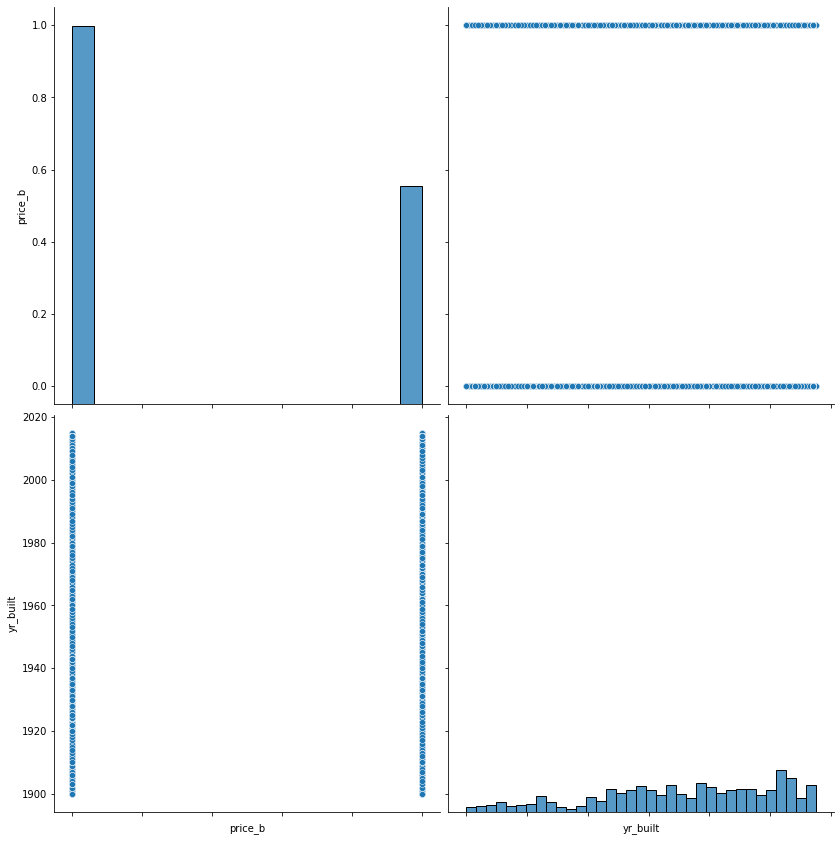

In [36]:
with sns.plotting_context():
  g = sns.pairplot(hdf[['price','yr_built']], palette='tab20',size=6)

g.set(xticklabels=[]);